# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from numpy.polynomial import Polynomial
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


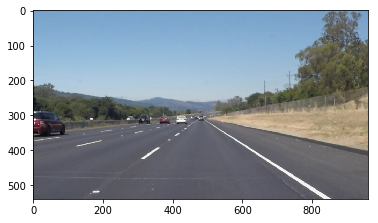

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def region_of_interest2(img, vertices):
    cv2.fillPoly(img, vertices, [0, 0, 0])
    return img


def draw_lines_orig(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    left_x = []
    left_y = []
    right_x = []
    right_y = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = (y2 - y1) / (x2 - x1)
            if x1 > x_mid and slope > 0.5:
                right_x.append(x1)
                right_x.append(x2)
                right_y.append(y1)
                right_y.append(y2)
            elif x1 < x_mid and slope < -0.5:
                left_x.append(x1)
                left_x.append(x2)
                left_y.append(y1)
                left_y.append(y2)

    imshape = img.shape
    max_y = imshape[0]
    max_x = imshape[1]
    left_a = 0
    right_a= 0
    if len(left_x) > 0 and len(left_y) > 0:
        left_a, left_b = np.polyfit(left_x, left_y, 1)
        left_y1 = max_y
        left_x1 = int((left_y1 - left_b) / left_a)
        left_y2 = top_y
        left_x2 = int((left_y2 - left_b) / left_a)
        print(left_x1, left_y1, left_x2, left_y2)
        cv2.line(img, (left_x1, left_y1), (left_x2, left_y2), color, thickness)

    if len(right_x) > 0 and len(right_y) > 0:
        right_a, right_b = np.polyfit(right_x, right_y, 1)
        right_y1 = max_y
        right_x1 = int((right_y1 - right_b) / right_a)
        right_y2 = top_y
        right_x2 = int((right_y2 - right_b) / right_a)
        cv2.line(img, (right_x1, right_y1), (right_x2, right_y2), color, thickness)

    return left_a, right_a


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.

    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,
                            maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    left_a, right_a = draw_lines(line_img, lines)
    return left_a, right_a, line_img


# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
input_images_names = os.listdir("test_images/")

print(input_images_names)

['solidYellowCurve.jpg', 'solidYellowLeft.jpg', 'solidYellowCurve2.jpg', 'solidWhiteRight.jpg', 'whiteCarLaneSwitch.jpg', 'solidWhiteCurve.jpg']


## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [10]:
# Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

def process_image_from_file(input_name_name):
    # reading in an image
    image = mpimg.imread('test_images/' + input_image_name)

    # debug = show intermediate results as well
    #fig, ((a, b, c, d, e, f, g)) = plt.subplots(1, 7, sharey=False, figsize=(20,50))
    fig, ((a, g)) = plt.subplots(1, 2, sharey=False, figsize=(120,50))
    
    output_image = process_image(image)
    
    # printing out some stats and plotting
    # print('This image is:', type(image), 'with dimensions:', image.shape)
    #a.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')
    #a.set_title("Original")
    
    g.imshow(output_image)
    g.set_title('Weighed')

    output_image_name = 'test_images_output/' + input_image_name
    mpimg.imsave(output_image_name, image_weighed)
   
    
def process_image(image):    

    # Grayscale
    image_grayscale = grayscale(image)
    #b.imshow(image_grayscale, cmap='gray')
    #b.set_title('Grayscale')

    # Gaussian smoothing /blurring
    kernel_size = 7
    image_gaussian_blurring = gaussian_blur(image_grayscale, kernel_size)
    #c.imshow(image_gaussian_blurring, cmap='gray')
    #c.set_title('Gaussian blurring (%d)' % kernel_size)

    # Canny
    low_threshold = 40
    high_threshold = 120
    image_canny = canny(image_gaussian_blurring, low_threshold, high_threshold)
    #d.imshow(image_canny, cmap='gray')
    #d.set_title('Canny (low %d and high %d)' % (low_threshold, high_threshold))

    # Apply mask to relevant part of image
    imshape = image_gaussian_blurring.shape
    max_y = imshape[0]
    max_x = imshape[1]  
    #print(imshape)
    # straight
    #top_y = 330
    #vertices = np.array([[(0, max_y),(460, top_y), (510, top_y), (max_x, max_y)]], dtype=np.int32)
    # corner right
    #top_y = 400
    vertices = np.array([[(0, max_y),(top_x_left, top_y), (top_x_right, top_y), (max_x, max_y)]], dtype=np.int32)   
    image_mask = region_of_interest(image_canny, vertices)
    #e.imshow(image_mask, cmap='gray')
    #e.set_title('Masked unrelevant parts')

    # Apply mask 2 to relevant part of image
    vertices2 = np.array([[(mask2_left, max_y), (mask2_center, mask2_top), (mask2_right, max_y)]], dtype=np.int32)
    image_mask2 = region_of_interest2(image_mask, vertices2)
    
    # Hough transformation
    rho = 2 # 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 10 # 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 30 # 40 # minimum number of pixels making up a line
    max_line_gap = 20    # maximum gap in pixels between connectable line segments
    left_a, right_a, image_after_hough = hough_lines(image_mask2, rho, theta, threshold, min_line_length, max_line_gap)
    #f.imshow(image_after_hough, cmap='gray')
    #f.set_title('Hough')

    # Weight line
    image_weighted = weighted_img(image_after_hough, image)
    
    return image_weighted
    
#for input_image_name in input_images_names:
#    process_image(input_image_name)
# input_image_name = 'solidWhiteRight.jpg'



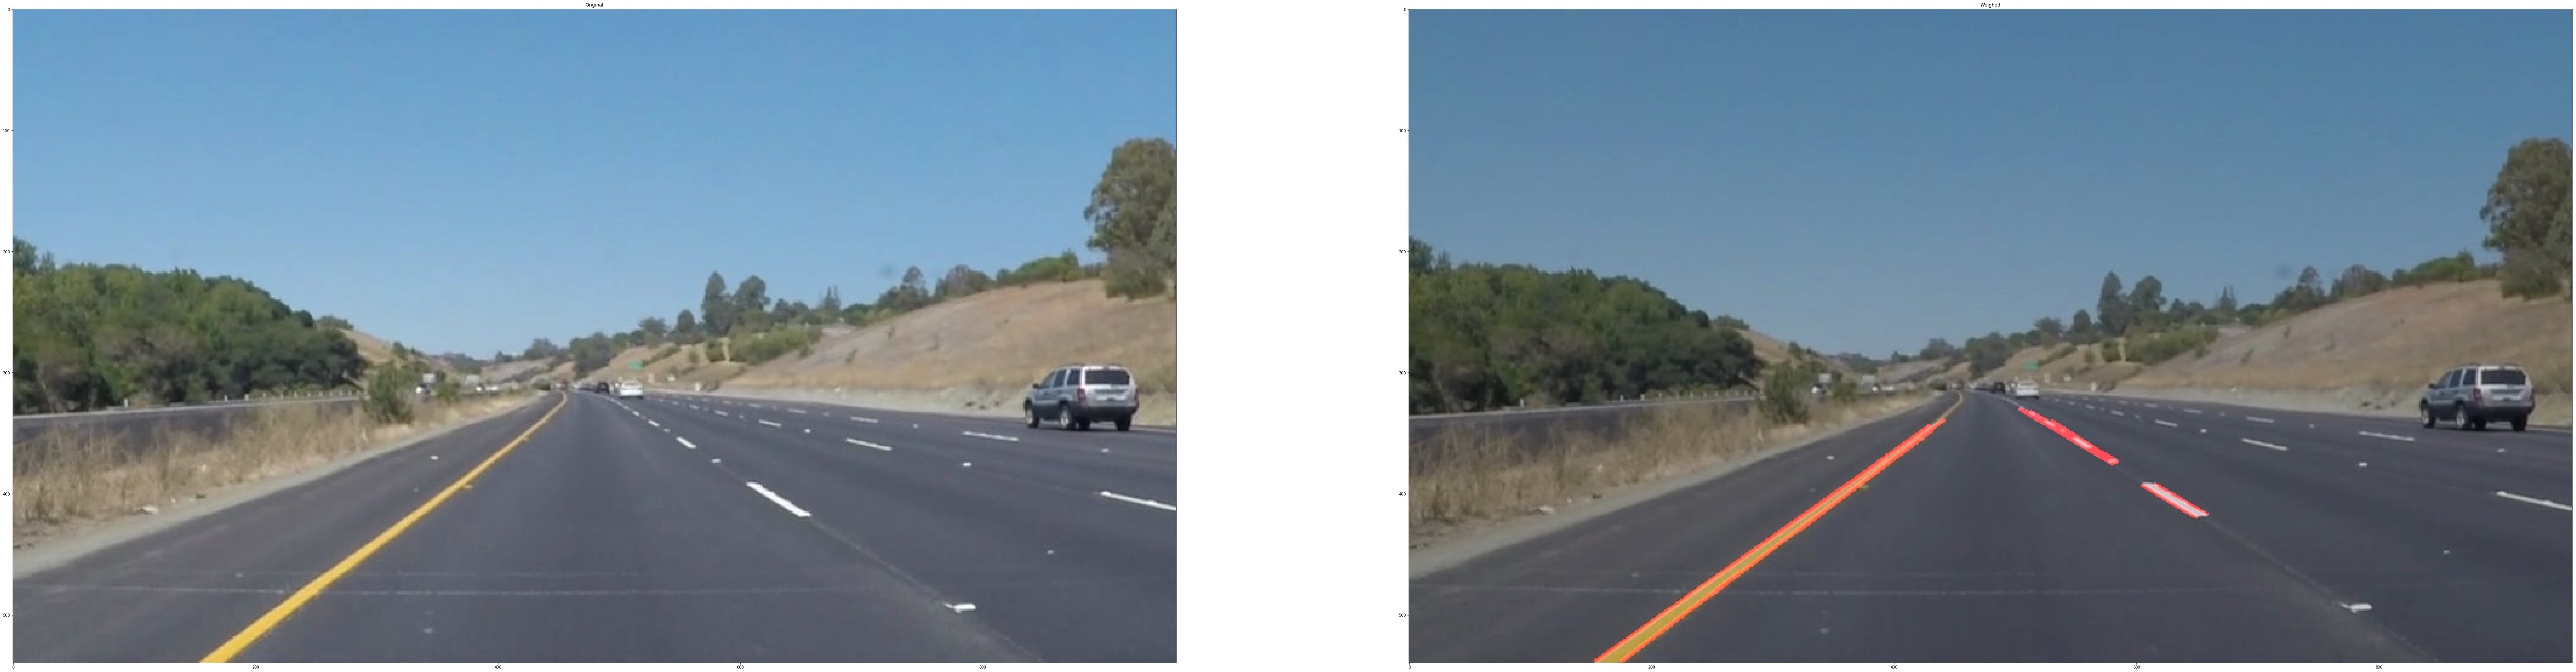

In [99]:
input_image_name = 'solidYellowCurve.jpg'
process_image(input_image_name)


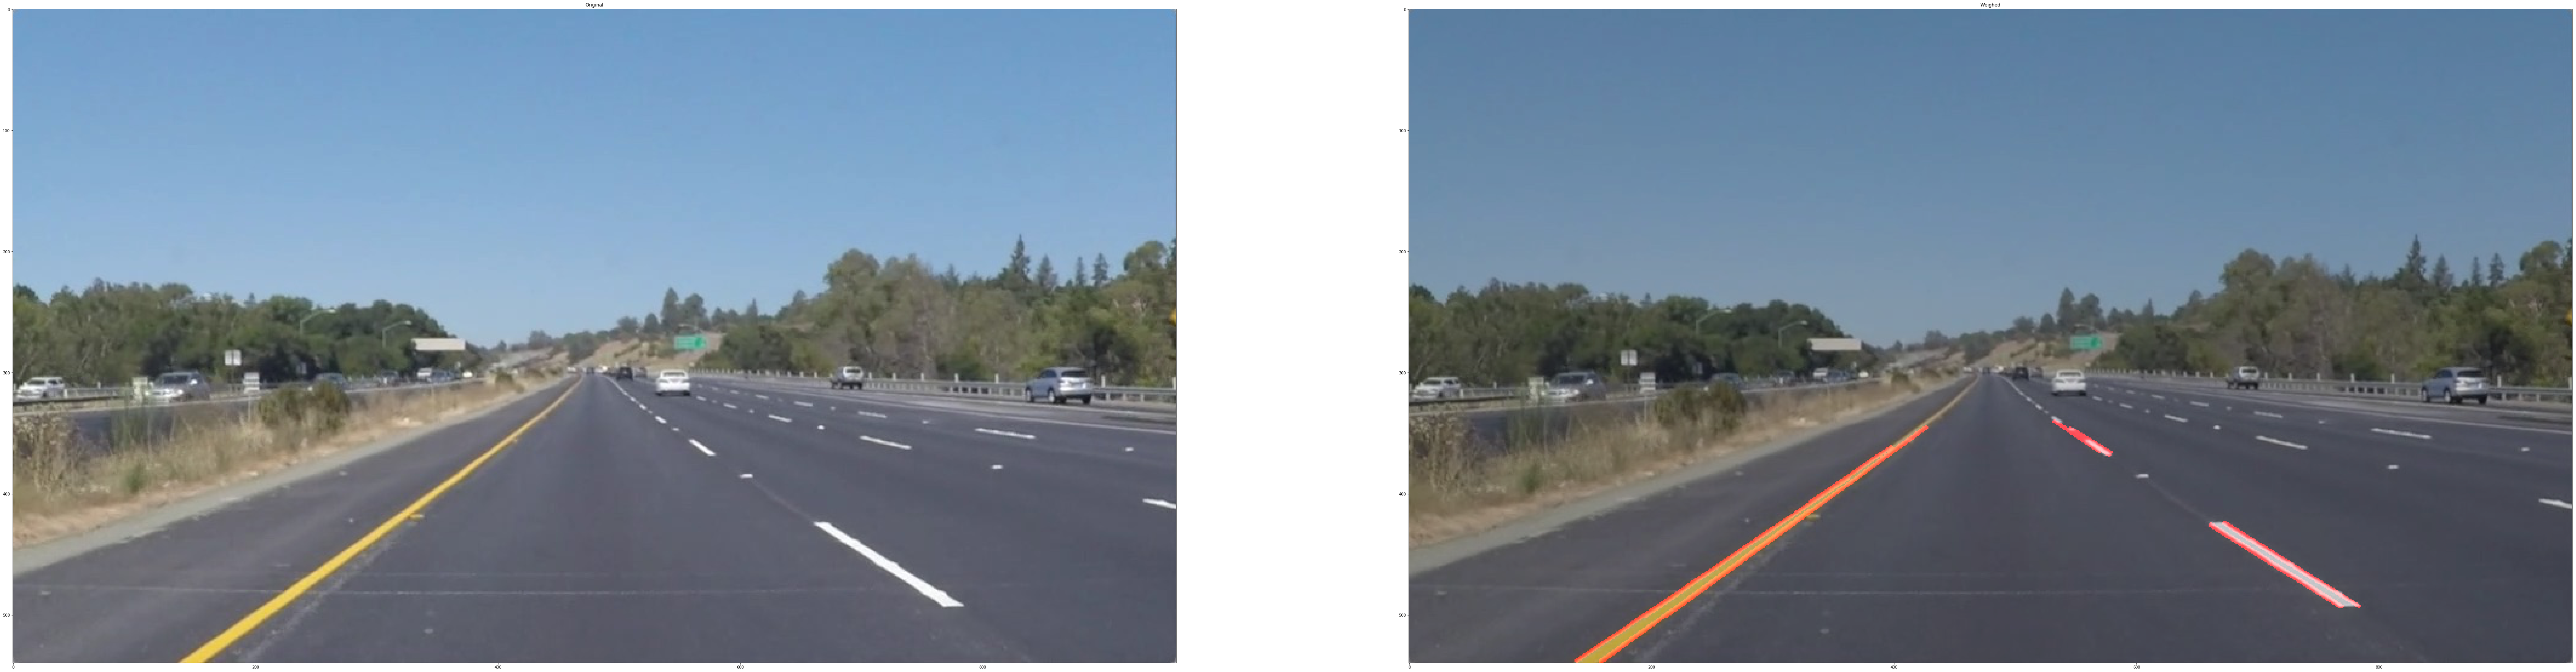

In [98]:
input_image_name = 'solidYellowLeft.jpg'
process_image(input_image_name)

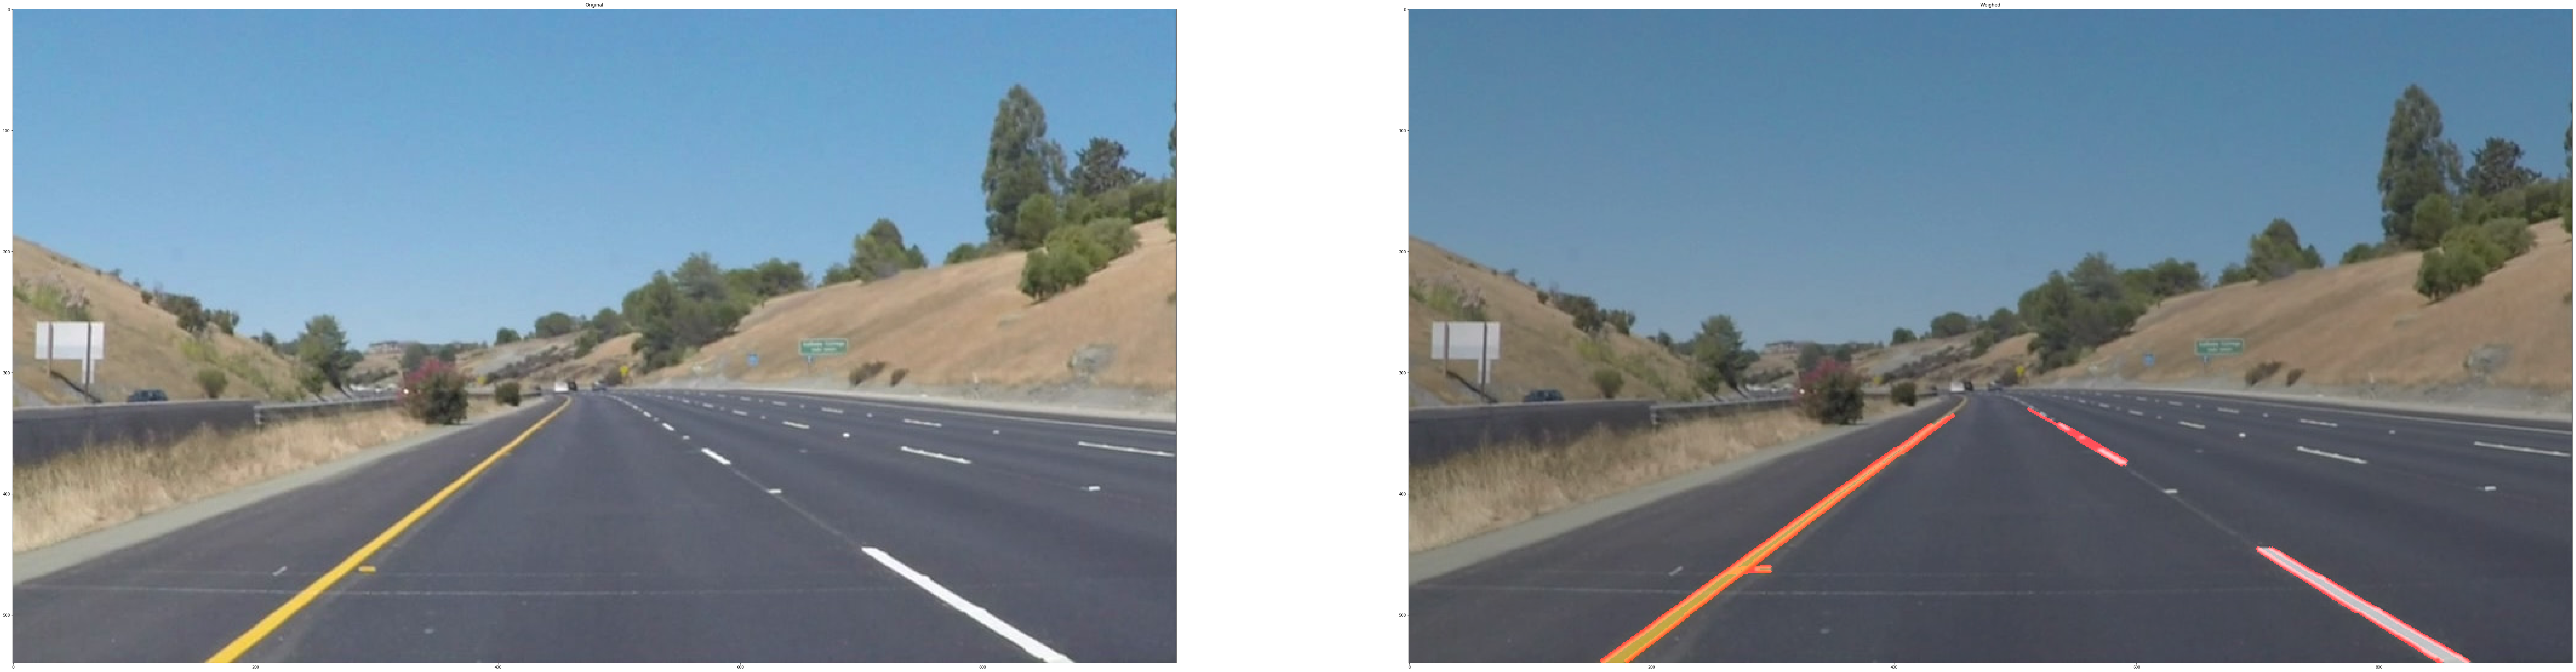

In [96]:
input_image_name = 'solidYellowCurve2.jpg'
process_image(input_image_name)


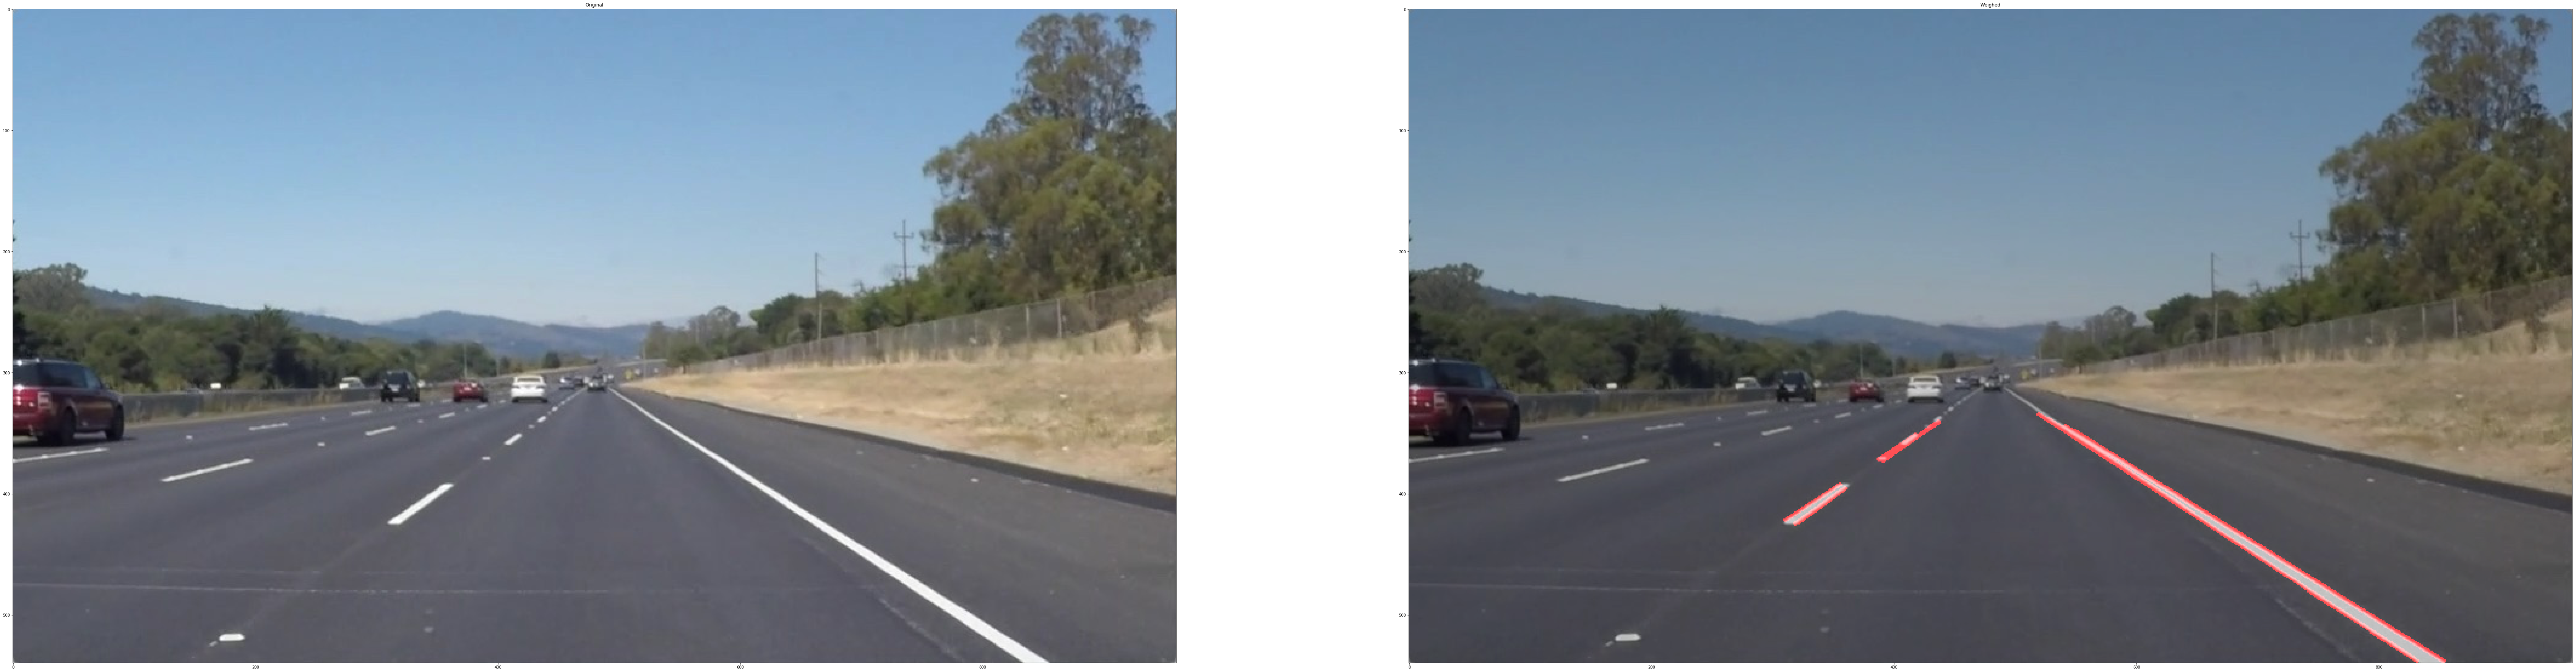

In [95]:
input_image_name = 'solidWhiteRight.jpg'

process_image(input_image_name)


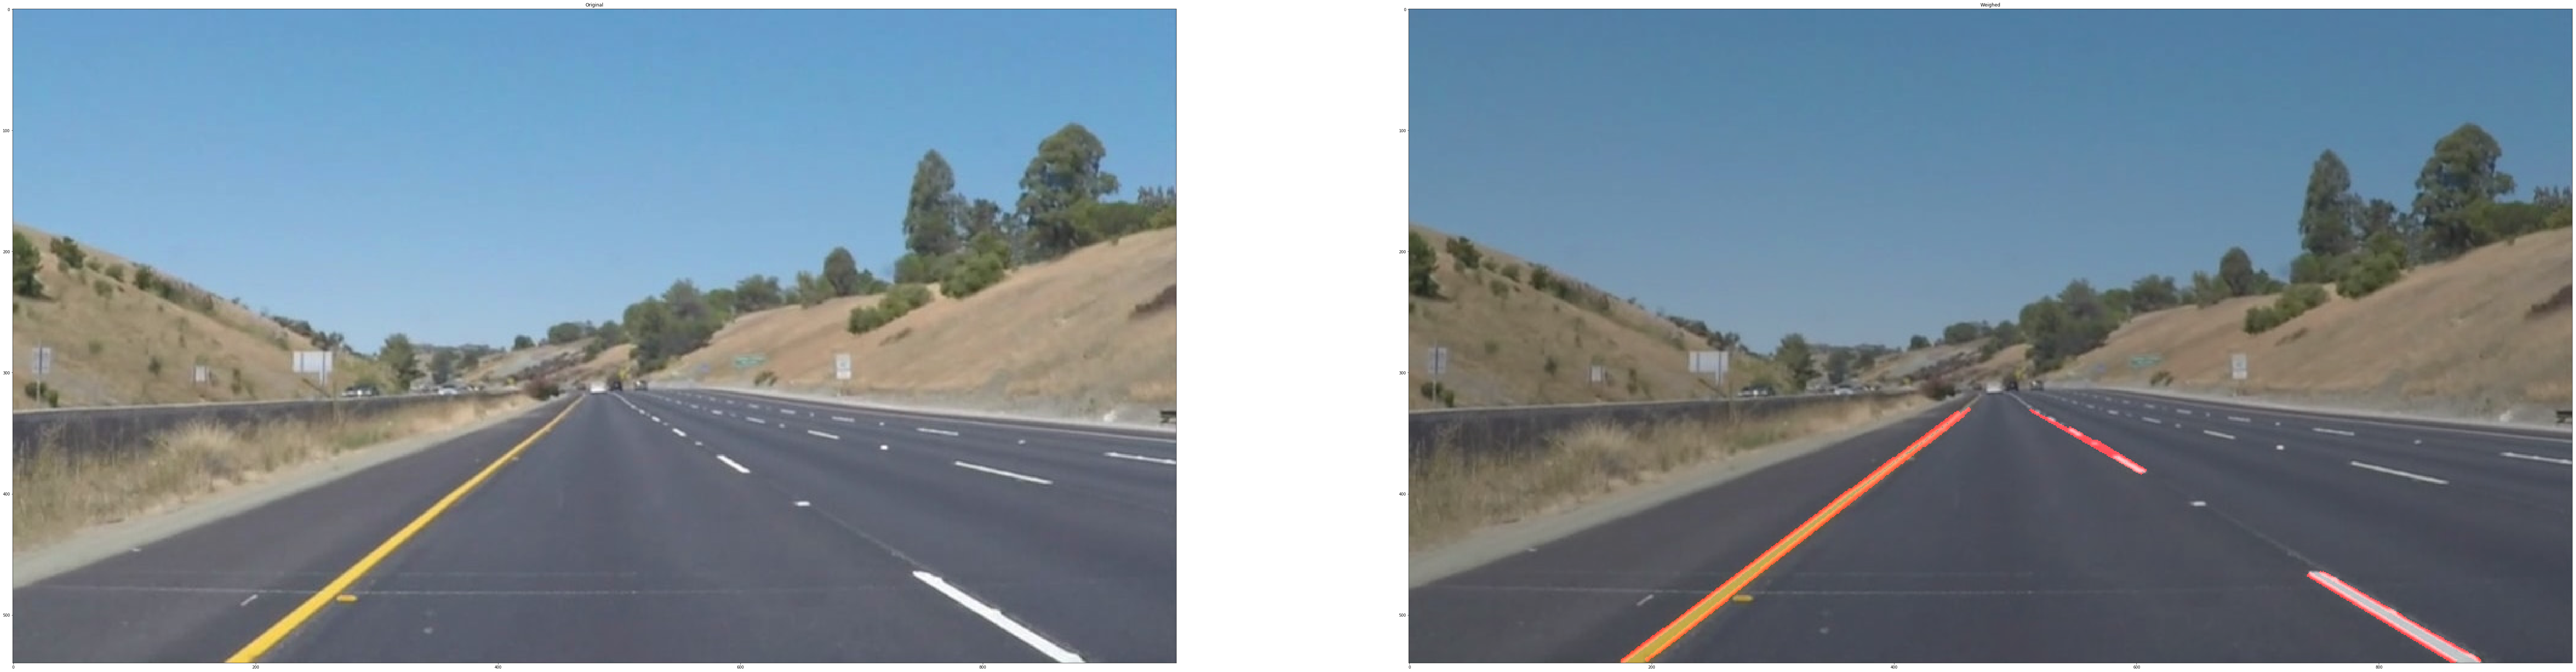

In [94]:
input_image_name = 'whiteCarLaneSwitch.jpg'

process_image(input_image_name)


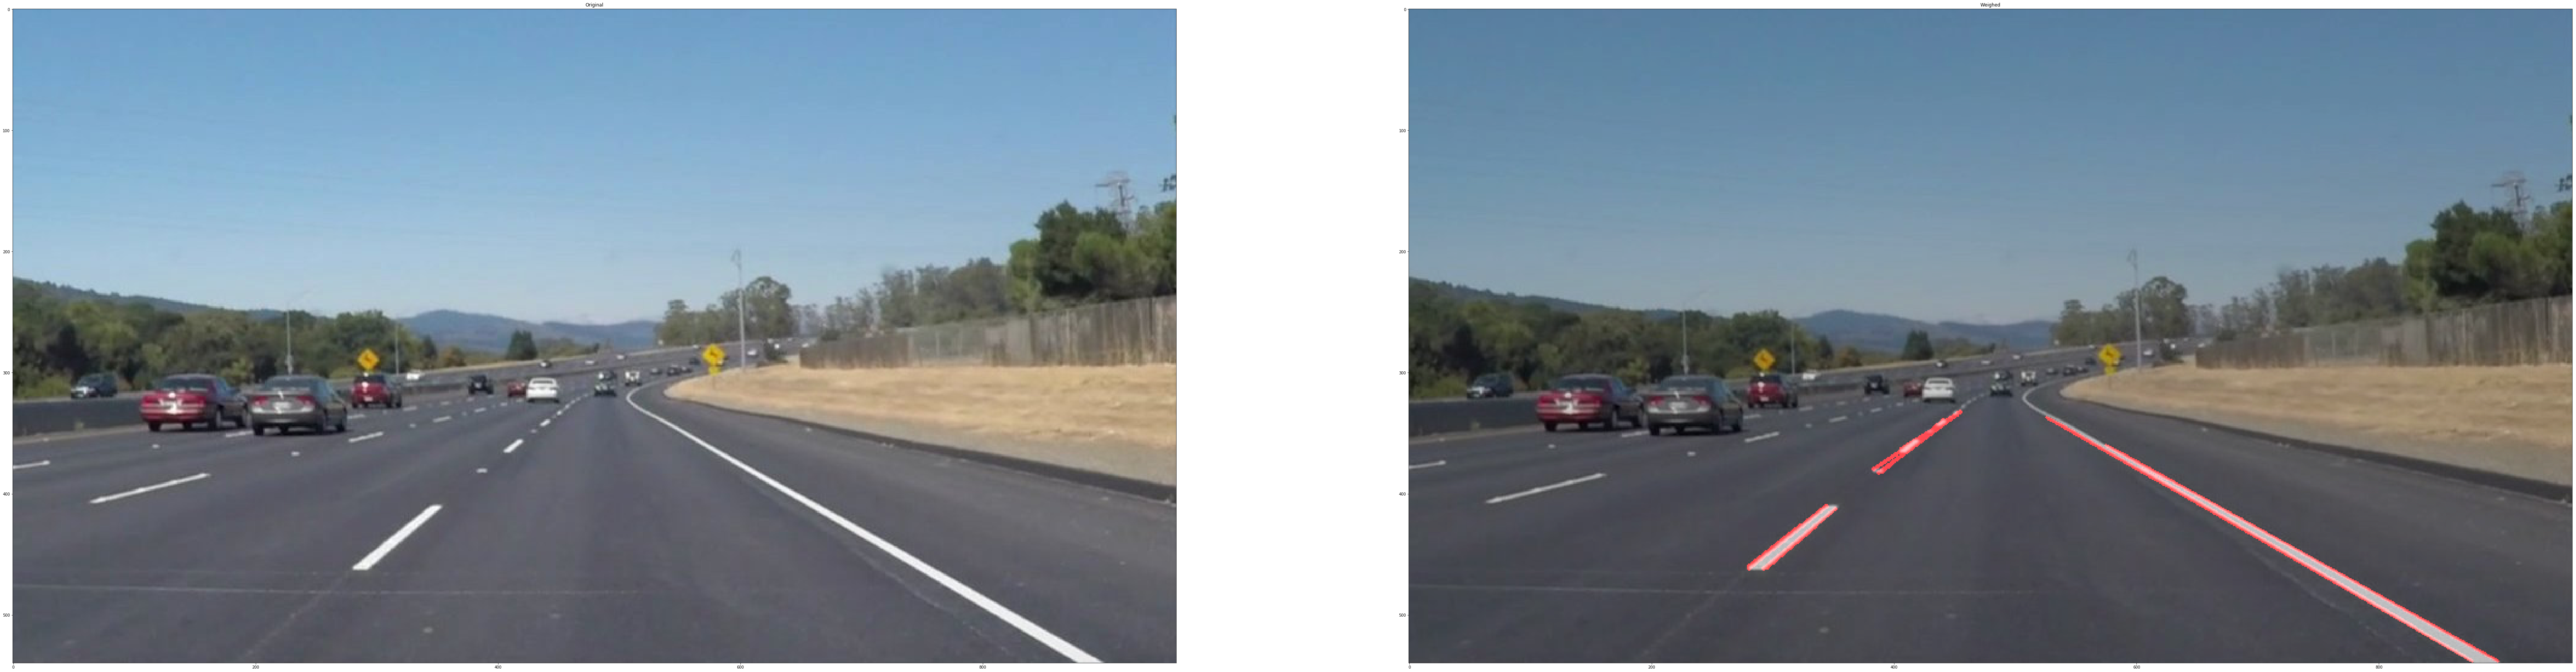

In [93]:
input_image_name = 'solidWhiteCurve.jpg'

process_image(input_image_name)


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
#def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

#    return result

Let's try the one with the solid white lane on the right first ...

In [225]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
top_y = 330
top_x_left = 460
top_x_right = 510
x_mid = 500
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4



100%|█████████▉| 221/222 [00:03<00:00, 63.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 2.45 s, sys: 600 ms, total: 3.05 s
Wall time: 3.53 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [226]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [228]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
top_y = 330
top_x_left = 460
top_x_right = 510
x_mid = 500
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4



100%|█████████▉| 681/682 [00:11<00:00, 61.27it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 8.64 s, sys: 2.06 s, total: 10.7 s
Wall time: 11.8 s


In [229]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [11]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
top_y = 450
top_x_left = 700
top_x_right = 700
x_mid = 700
x_margin_lower_left = 200
x_margin_lower_right = 150
lower_margin = 60
mask2_left = 300
mask2_center = 650
mask2_right = 900
mask2_top = 450
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

214 720 607 450
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  2%|▏         | 6/251 [00:00<00:04, 53.63it/s]

214 720 607 450
216 720 609 450
139 720 684 450
213 720 615 450
212 720 617 450
214 720 614 450
223 720 622 450
218 720 618 450
233 720 616 450
236 720 615 450
232 720 617 450
229 720 615 450


  8%|▊         | 19/251 [00:00<00:04, 53.36it/s]

228 720 616 450
238 720 614 450
248 720 615 450
260 720 609 450
226 720 613 450
235 720 609 450
232 720 613 450
231 720 612 450
240 720 607 450
234 720 600 450
229 720 608 450


 12%|█▏        | 31/251 [00:00<00:04, 54.69it/s]

230 720 608 450
228 720 610 450
229 720 613 450
234 720 603 450
235 720 605 450
232 720 602 450
232 720 603 450
224 720 607 450
226 720 598 450
225 720 602 450
217 720 605 450
227 720 599 450


 17%|█▋        | 42/251 [00:00<00:03, 54.08it/s]

218 720 604 450
232 720 601 450
185 720 637 450
211 720 617 450
218 720 611 450
218 720 606 450
212 720 613 450
219 720 614 450
209 720 618 450
218 720 614 450
229 720 608 450


 19%|█▊        | 47/251 [00:00<00:05, 39.62it/s]

221 720 621 450
222 720 612 450
223 720 615 450
181 720 642 450


 21%|██        | 52/251 [00:01<00:05, 36.10it/s]

231 720 612 450
228 720 615 450
248 720 616 450
221 720 611 450
237 720 606 450


 22%|██▏       | 56/251 [00:01<00:06, 31.93it/s]

231 720 610 450


 24%|██▍       | 60/251 [00:01<00:06, 28.99it/s]

227 720 605 450
229 720 609 450
230 720 606 450
236 720 610 450
232 720 608 450
140 720 675 450


 25%|██▌       | 64/251 [00:01<00:06, 28.18it/s]

226 720 610 450
247 720 608 450
227 720 627 450
209 720 643 450
224 720 622 450
223 720 620 450
221 720 610 450


 29%|██▉       | 73/251 [00:01<00:06, 29.57it/s]

233 720 613 450
234 720 623 450
236 720 617 450
242 720 619 450
178 720 678 450
242 720 620 450


 31%|███       | 77/251 [00:02<00:06, 28.61it/s]

254 720 616 450
243 720 620 450
246 720 625 450
248 720 625 450
249 720 620 450


 32%|███▏      | 80/251 [00:02<00:06, 28.22it/s]

252 720 617 450


 35%|███▍      | 87/251 [00:02<00:05, 29.38it/s]

258 720 616 450
261 720 619 450
251 720 618 450
215 720 650 450
266 720 614 450
260 720 620 450
260 720 623 450


 37%|███▋      | 93/251 [00:02<00:05, 27.66it/s]

265 720 614 450
268 720 622 450
270 720 621 450
270 720 614 450
267 720 619 450
272 720 612 450


 39%|███▊      | 97/251 [00:02<00:05, 29.45it/s]

274 720 610 450
258 720 627 450
205 720 666 450
276 720 615 450
267 720 610 450
265 720 612 450


 40%|████      | 101/251 [00:02<00:04, 30.57it/s]

266 720 609 450
257 720 607 450


 42%|████▏     | 105/251 [00:02<00:04, 30.14it/s]

260 720 611 450
248 720 619 450
248 720 614 450
229 720 736 450
286 720 636 450
136 720 649 450


 45%|████▌     | 113/251 [00:03<00:04, 31.42it/s]

220 720 594 450
212 720 594 450
210 720 576 450
206 720 592 450
214 720 585 450
202 720 585 450


 48%|████▊     | 121/251 [00:03<00:03, 32.54it/s]

223 720 595 450
186 720 676 450
217 720 614 450


 51%|█████▏    | 129/251 [00:03<00:04, 29.35it/s]

202 720 584 450
195 720 596 450
149 720 753 450


 54%|█████▍    | 135/251 [00:04<00:04, 26.97it/s]

195 720 605 450
193 720 595 450
189 720 589 450
185 720 591 450
181 720 594 450


 57%|█████▋    | 142/251 [00:04<00:03, 27.98it/s]

187 720 589 450
187 720 586 450
184 720 600 450
193 720 579 450
169 720 620 450
182 720 598 450


 59%|█████▉    | 148/251 [00:04<00:03, 26.93it/s]

185 720 573 450
-41 720 804 450
116 720 667 450
157 720 619 450
171 720 616 450


 60%|██████    | 151/251 [00:04<00:04, 23.77it/s]

164 720 617 450
166 720 618 450
174 720 611 450
179 720 602 450


 63%|██████▎   | 157/251 [00:04<00:04, 21.56it/s]

144 720 626 450
116 720 661 450
169 720 609 450
172 720 611 450
161 720 598 450
157 720 609 450


 65%|██████▍   | 163/251 [00:05<00:03, 22.89it/s]

160 720 595 450
154 720 598 450
156 720 601 450
152 720 586 450
161 720 608 450


 66%|██████▌   | 166/251 [00:05<00:03, 22.68it/s]

164 720 605 450
158 720 627 450
168 720 619 450
174 720 623 450
176 720 634 450


 69%|██████▊   | 172/251 [00:05<00:03, 22.25it/s]

194 720 631 450
197 720 626 450
212 720 633 450
208 720 627 450
206 720 620 450
217 720 613 450


 71%|███████▏  | 179/251 [00:05<00:02, 24.69it/s]

204 720 611 450
219 720 616 450
209 720 609 450
162 720 652 450
213 720 616 450
219 720 611 450
226 720 614 450


 74%|███████▍  | 186/251 [00:06<00:02, 23.36it/s]

228 720 612 450
218 720 612 450
222 720 618 450
228 720 618 450
225 720 625 450


 76%|███████▋  | 192/251 [00:06<00:02, 24.79it/s]

233 720 625 450
238 720 624 450
241 720 619 450
242 720 609 450
239 720 614 450
255 720 611 450


 79%|███████▉  | 198/251 [00:06<00:02, 24.08it/s]

250 720 612 450
243 720 614 450
255 720 610 450
242 720 614 450
243 720 613 450


 80%|████████  | 201/251 [00:06<00:02, 24.37it/s]

246 720 614 450
249 720 617 450
245 720 616 450
187 720 689 450
255 720 615 450
247 720 608 450


 82%|████████▏ | 207/251 [00:07<00:01, 24.34it/s]

252 720 610 450
264 720 608 450
253 720 615 450
255 720 612 450
263 720 607 450
263 720 613 450


 86%|████████▋ | 217/251 [00:07<00:01, 27.85it/s]

259 720 621 450
269 720 608 450
266 720 612 450
263 720 610 450
266 720 620 450
266 720 620 450
279 720 621 450


 89%|████████▉ | 224/251 [00:07<00:00, 29.50it/s]

274 720 615 450
270 720 616 450
272 720 610 450
277 720 615 450
277 720 612 450
267 720 610 450
277 720 612 450


 91%|█████████ | 228/251 [00:07<00:00, 30.51it/s]

208 720 644 450
264 720 611 450
270 720 614 450
271 720 613 450
269 720 610 450
259 720 614 450
265 720 602 450


 94%|█████████▍| 236/251 [00:07<00:00, 31.54it/s]

254 720 616 450
260 720 608 450
257 720 615 450
256 720 614 450
255 720 614 450
251 720 609 450
252 720 611 450


 97%|█████████▋| 244/251 [00:08<00:00, 30.44it/s]

267 720 611 450
267 720 611 450
262 720 612 450
263 720 614 450
257 720 606 450
262 720 602 450
254 720 603 450


100%|██████████| 251/251 [00:08<00:00, 29.70it/s]

250 720 608 450
251 720 606 450
178 720 681 450
246 720 606 450
248 720 620 450
251 720 616 450


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 5.59 s, sys: 1.85 s, total: 7.44 s
Wall time: 9.45 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))